In [1]:
## Import packages to read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

In [41]:
## Data does not have column headers, add these when importing

column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking as it is a large file

df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

In [42]:
## As we are interested in only selected columns, restructure the data for these columns
## exclude transaction ID, secondary address (SAON), PPD category type, and record status
df = df.drop(columns = ['transaction_ID', 'SAON', 'PPD_category_type', 'record_status'])

In [43]:
## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023150 entries, 0 to 1023149
Data columns (total 14 columns):
price            1023150 non-null int64
transfer_date    1023150 non-null datetime64[ns]
postcode         1017226 non-null object
property_type    1023150 non-null object
new_build        1023150 non-null object
duration         1023150 non-null object
PAON             1023150 non-null object
street           1003520 non-null object
locality         385531 non-null object
town_city        1023150 non-null object
district         1023150 non-null object
county           1023150 non-null object
month            1023150 non-null int64
year             1023150 non-null int64
dtypes: datetime64[ns](1), int64(3), object(10)
memory usage: 109.3+ MB


### Filter the data by specific criteria

In [44]:
## Explore the data with different criteria
criteria01 = df.price > 1000000
criteria02 = df.new_build == 'Y'

## Return a table, with selected columns, based on those criteria
df_query = df[criteria01 & criteria02].reset_index()
df_query[['price', 'property_type', 'new_build','town_city']].head(10)

,price,property_type,new_build,town_city
0,1325000,D,Y,BISHOP'S STORTFORD
1,1250000,D,Y,HARPENDEN
2,1425000,D,Y,BISHOP'S STORTFORD
3,1150000,F,Y,WINCHESTER
4,1200000,D,Y,BISHOP'S STORTFORD
5,1184389,F,Y,LONDON
6,1139750,F,Y,LONDON
7,1136650,F,Y,LONDON
8,1068750,F,Y,LONDON
9,1100000,F,Y,LONDON


In [45]:
## Summary statistics of dataset
avg_price = np.mean(df.price)
median_price = np.median(df.price)

print("Overall 2018 average price was : £" + format(avg_price, ",.0f"))
print("Overall 2018 median price was : £" + format(median_price, ",.0f"))

## Average price paid in London
city_select = 'London'
avg_price_paid = round(df[df.town_city == city_select.upper()].price.mean(), 2)
print("Average 2018 price paid in " + city_select + " was: £" + format(avg_price_paid, ",.0f"))

Overall 2018 average price was : £349,707
Overall 2018 median price was : £230,000
Average 2018 price paid in London was: £1,019,656


### Compare multiple cities prices paid

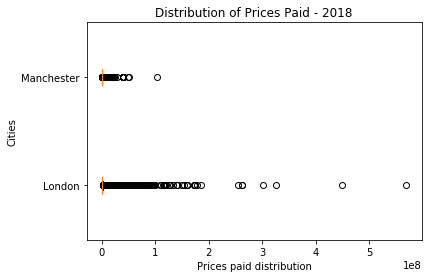

In [46]:
city_option01 = 'London'
city_option02 = 'Manchester'

city01 = df[df['town_city'] == city_option01.upper()]
city02 = df[df['town_city'] == city_option02.upper()]

plt.boxplot([city01.price, city02.price], labels=[city_option01, city_option02], 
            autorange=True, widths=0.15, vert=False)
plt.title('Distribution of Prices Paid - 2018')
plt.xlabel('Prices paid distribution')
plt.ylabel('Cities')
plt.show()

In [124]:
## Preprocess data for regression analysis
## by converting cateogories into numerical values

## Create new column that trims the postcodes into generalized postcodes (remove last 3 charaacters)
df['trim_postcode'] = [str(x)[:-4] for x in df.postcode.tolist()]
df['trim_postcode'].shape

# Create a separate DataFrame for only unique generalized postcodes
unique_postcodes = pd.DataFrame(df.trim_postcode.unique(), columns = ['trim_postcode']).reset_index()
df['prep_postcodes'] = [unique_postcodes['trim_postcode'][x] for x in df.trim_postcode]
df['prep_postcodes'].head()
#unique_postcodes.head()
#df['prep_postcodes']

KeyError: 'SK7'

In [117]:
## Create new columns to enumerate the string data in Property Type and New Build columns
prep_prop_type = {'D' : 1, 
                  'S' : 2, 
                  'T' : 3, 
                  'F' : 4, 
                  'O' : 5}

prep_new_build = {'N': 0, 
                  'Y': 1}

df['prep_prop_type'] = [prep_prop_type[x] for x in df.property_type]
df['prep_new_build'] = [prep_new_build[x] for x in df.new_build]
df[['price','trim_postcode','property_type','prep_prop_type', 'new_build', 'prep_new_build']].head()

,price,trim_postcode,property_type,prep_prop_type,new_build,prep_new_build
0,770000,SK7,D,1,N,0
1,253500,M6,D,1,N,0
2,231950,WA3,D,1,Y,1
3,112500,OL6,S,2,N,0
4,184995,M46,S,2,Y,1


In [49]:
df['new_build'].head(10)

0    N
1    N
2    Y
3    N
4    Y
5    Y
6    N
7    Y
8    Y
9    Y
Name: new_build, dtype: object

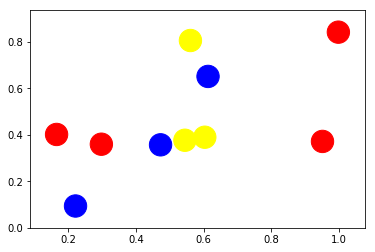

In [50]:
# random number representing size
x1 = np.random.random(10)

# generate random array of property types
property_types = ['condo', 'house', 'commercial']
x2 = np.random.choice(property_types,10)

# random number representing price
y = np.random.random(10)

# create mapping from property type to matplot colour
property_type_colour_map = {'condo':'red','house':'blue','commercial':'yellow'}

# create array of colours from list comprehension
colour_array = [property_type_colour_map[i] for i in x2]

plt.scatter(x1, y, c=colour_array, s=500)
plt.show()